In [1]:
import timeit 
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
# Import modules
import math
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 500)


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import os
import sys
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Config
folder = './datasets/brasilian-houses-to-rent/'
file = 'houses_to_rent.csv'

In [3]:
df = pd.read_csv(os.path.join(folder, file))
df.head()

,Unnamed: 0,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
0,0,1,240,3,3,4,-,acept,furnished,R$0,"R$8,000","R$1,000",R$121,"R$9,121"
1,1,0,64,2,1,1,10,acept,not furnished,R$540,R$820,R$122,R$11,"R$1,493"
2,2,1,443,5,5,4,3,acept,furnished,"R$4,172","R$7,000","R$1,417",R$89,"R$12,680"
3,3,1,73,2,2,1,12,acept,not furnished,R$700,"R$1,250",R$150,R$16,"R$2,116"
4,4,1,19,1,1,0,-,not acept,not furnished,R$0,"R$1,200",R$41,R$16,"R$1,257"


In [5]:
cols = ['floor','hoa','rent amount','property tax','fire insurance','total']
def __GetIntCols(df, collist):
    for col in collist:
        df[col] = df[col].str.extract('(\d+)').astype(float)
    return(df)

clean_df = __GetIntCols(df, cols)


In [6]:
clean_df[cols] = clean_df[cols].fillna(0).astype(int)
clean_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
clean_df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
0,1,240,3,3,4,0,acept,furnished,0,8,1,121,9
1,0,64,2,1,1,10,acept,not furnished,540,820,122,11,1
2,1,443,5,5,4,3,acept,furnished,4,7,1,89,12
3,1,73,2,2,1,12,acept,not furnished,700,1,150,16,2
4,1,19,1,1,0,0,not acept,not furnished,0,1,41,16,1


In [7]:
# Check for any null values in the data
print("% Missing data in each column \n",round((clean_df.isnull().sum(axis = 0)/len(clean_df))*100,2))
print("This shows us that there are no missing values in the dataframe, we will need to deal with these before modeling")

% Missing data in each column 
 city             0.00
area             0.00
rooms            0.00
bathroom         0.00
parking spaces   0.00
floor            0.00
animal           0.00
furniture        0.00
hoa              0.00
rent amount      0.00
property tax     0.00
fire insurance   0.00
total            0.00
dtype: float64
This shows us that there are no missing values in the dataframe, we will need to deal with these before modeling


In [8]:
# There is only one categorical variable, rest are numeric
clean_df["animal"].value_counts()

acept        4666
not acept    1414
Name: animal, dtype: int64

In [9]:
# There is only one categorical variable, rest are numeric
clean_df["furniture"].value_counts()

not furnished    4498
furnished        1582
Name: furniture, dtype: int64

In [10]:
# Lets look at the rest of the fields - we can check out the numeric data using describe method
clean_df.describe()

,city,area,rooms,bathroom,parking spaces,floor,hoa,rent amount,property tax,fire insurance,total
count,6080.00,6080.00,6080.00,6080.00,6080.00,6080.00,6080.00,6080.00,6080.00,6080.00,6080.00
mean,0.86,151.14,2.49,2.34,1.76,5.67,219.79,42.75,185.93,58.20,22.26
std,0.34,375.56,1.13,1.44,1.61,6.17,306.34,171.77,234.91,49.31,121.40
min,0.00,10.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,3.00,1.00
25%,1.00,58.00,2.00,1.00,1.00,0.00,1.00,2.00,1.00,23.00,2.00
50%,1.00,100.00,3.00,2.00,1.00,4.00,2.00,3.00,86.00,41.00,4.00
75%,1.00,200.00,3.00,3.00,2.00,9.00,465.00,6.00,280.00,77.00,8.00
max,1.00,24606.00,10.00,10.00,12.00,99.00,998.00,999.00,998.00,677.00,999.00


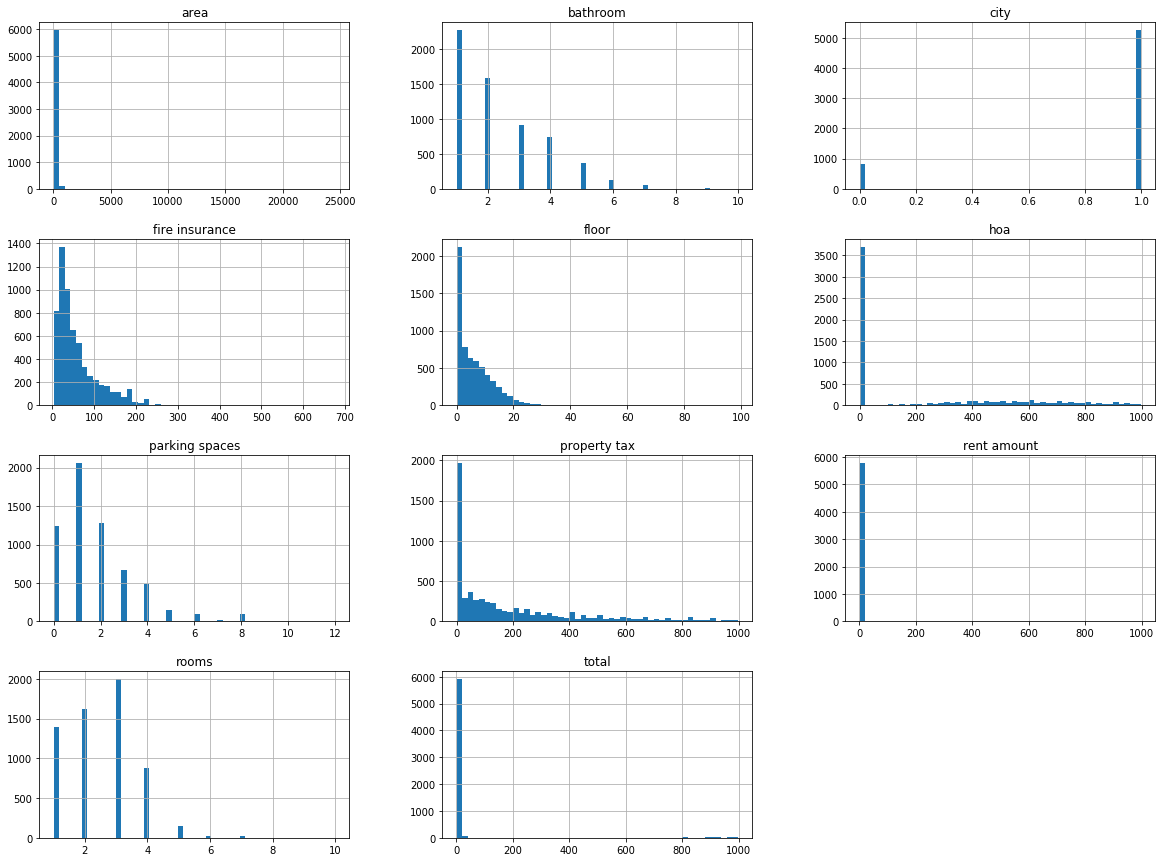

In [11]:
# Above data as plots
clean_df.hist(bins=50, figsize=(20,15))
plt.show()

In [12]:
# Looks like total values are not distributed accurately

In [14]:
# Step 4: Create test set

# Use sklearns train_test_split function

from sklearn.model_selection import train_test_split

# For a pure random sample which can be fetched again (random_state fixed)
train_set, test_set = train_test_split(clean_df, test_size = 0.2, random_state = 42)



 Original set distribution of rooms_cat 2   0.59
1   0.23
3   0.14
4   0.03
5   0.00
Name: rooms_cat, dtype: float64
 New set distribution of rooms_cat 2   0.59
1   0.23
3   0.14
4   0.03
5   0.00
Name: rooms_cat, dtype: float64


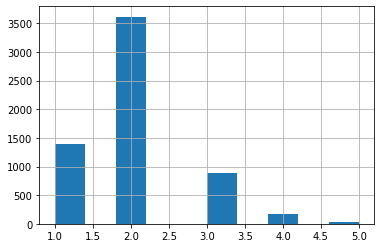

In [15]:

#For a stratified sample incase there is a variable we think affects the dependant more
# and we want split in test to be similar to train. First we create a categorical variable out of it
# Here we want to make sure our split test set has similar distribution as test set of this important variable

clean_df["rooms_cat"] = pd.cut(clean_df['rooms'],
                              bins = [0., 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels = [1,2,3,4,5]
                              )

clean_df['rooms_cat'].hist()

print(" Original set distribution of rooms_cat", clean_df['rooms_cat'].value_counts()/len(clean_df))

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(clean_df, clean_df['rooms_cat']):
    strat_train_set = clean_df.loc[train_index]
    strat_test_set = clean_df.loc[test_index]


print(" New set distribution of rooms_cat", strat_test_set['rooms_cat'].value_counts()/len(strat_test_set))

# Remove the new created categorical variable

for set_ in (strat_train_set, strat_test_set):
    set_.drop("rooms_cat", axis = 1, inplace = True)

In [16]:
# Step 5: Put the test set aside

housing = strat_train_set.copy()

In [17]:
housing.head(3)

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
1152,1,83,2,3,2,8,acept,not furnished,1,3,735,41,5
2073,1,123,3,3,0,0,acept,not furnished,0,4,42,61,4
593,1,130,2,2,0,6,acept,not furnished,1,3,71,51,5


Plot 1: Simple scatter plot of latitude and longitude
Plot 2: Scatter plot of latitude and longitude with density feature
Plot 3: Scatter plot with housing prices as color


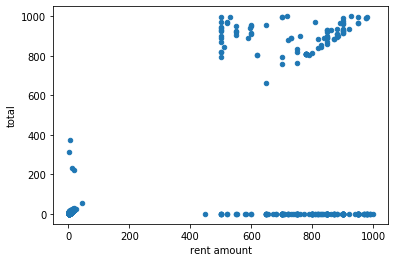

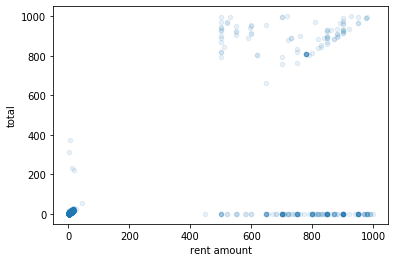

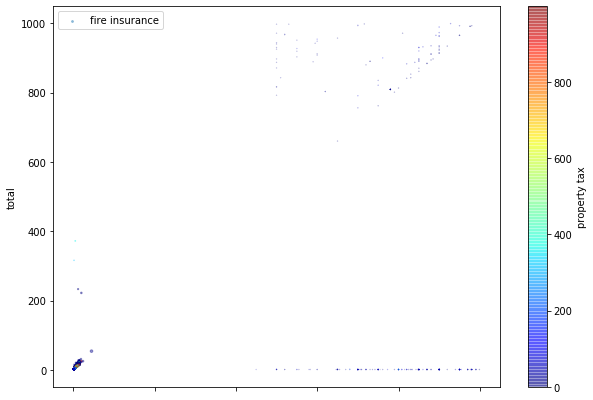

In [19]:
# Step 6: Exploring the data

# Some scatter plots with the continous data based on our understanding
# Here we have longitude and latitude, let's use that

print("Plot 1: Simple scatter plot of latitude and longitude")
housing.plot(kind='scatter', x='rent amount', y='total')

# Using density to see which areas are densly populated
print("Plot 2: Scatter plot of latitude and longitude with density feature")
housing.plot(kind='scatter', x='rent amount', y='total', alpha = 0.1)

# Adding more variable features to map color of circle (price) and size of circle (population)

print("Plot 3: Scatter plot with housing prices as color")
housing.plot(kind='scatter', x='rent amount', y='total', alpha = 0.4,
            s= housing["fire insurance"]/100, label= 'fire insurance', figsize = (10,7),
             c= "property tax", cmap = plt.get_cmap("jet"), colorbar= True
            )
plt.legend()

In [20]:
# Correlation with target variable
corr_matrix = housing.corr()
corr_matrix["total"].sort_values(ascending=False)

total             1.00
rent amount       0.56
area             -0.03
hoa              -0.06
city             -0.08
floor            -0.08
property tax     -0.09
fire insurance   -0.10
bathroom         -0.10
parking spaces   -0.13
rooms            -0.16
Name: total, dtype: float64

In [21]:
housing["bathrooms_per_rooms"] = housing["bathroom"]/housing["rooms"]
housing["area_per_rooms"] = housing["area"]/housing["rooms"]
housing["area_per_parkingspaces"] = housing["area"]/housing["parking spaces"]


In [22]:
# Correlation with target variable
corr_matrix = housing.corr()
corr_matrix["total"].sort_values(ascending=False)

total                     1.00
rent amount               0.56
bathrooms_per_rooms       0.03
area_per_parkingspaces    0.01
area_per_rooms           -0.02
area                     -0.03
hoa                      -0.06
city                     -0.08
floor                    -0.08
property tax             -0.09
fire insurance           -0.10
bathroom                 -0.10
parking spaces           -0.13
rooms                    -0.16
Name: total, dtype: float64

In [23]:
# Get a clean train dataset with separate label
 
housing = strat_train_set.drop("total", axis = 1)
housing_labels = strat_train_set["total"].copy()

In [25]:
strat_train_set.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
1152,1,83,2,3,2,8,acept,not furnished,1,3,735,41,5
2073,1,123,3,3,0,0,acept,not furnished,0,4,42,61,4
593,1,130,2,2,0,6,acept,not furnished,1,3,71,51,5
3463,1,340,4,6,4,0,acept,furnished,0,11,1,173,12
4709,1,100,3,1,1,2,acept,not furnished,1,3,92,39,4


In [26]:
# Step 7: Data Cleaning

# Categorical columns list
cat_cols = housing.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = housing.select_dtypes(include=['int', 'float']).columns.tolist()


# #Fill nas with median value

# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(strategy="median")

# #Median can only be computed on numerical attributes
# housing_num = housing.drop(cat_cols, axis = 1)

# imputer.fit(housing_num)  #imputer has computed median of each attribute and stored in its statistics_ instance variable
# X = imputer.transform(housing_num)
# housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)
housing_tr = housing


In [27]:
# Convert categorical variables to numeric - Ordinal Encoder
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

housing_cat = housing[["animal","furniture"]]
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
ordinal_encoder.categories_

[array(['acept', 'not acept'], dtype=object),
 array(['furnished', 'not furnished'], dtype=object)]

In [28]:

# Convert categorical variables to numeric - one hot encoder

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       ...,
       [1., 0., 1., 0.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.]])

In [29]:
cat_encoder.categories_

[array(['acept', 'not acept'], dtype=object),
 array(['furnished', 'not furnished'], dtype=object)]

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [32]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

#Median can only be computed on numerical attributes
housing_num = housing.drop(cat_cols, axis = 1)
housing_num_tr = num_pipeline.fit_transform(housing_num)


In [33]:
from sklearn.compose import ColumnTransformer

In [34]:
num_attribs = list(housing_num)
cat_attribs = ['animal','furniture']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

In [35]:

housing_prepared = full_pipeline.fit_transform(housing)

In [37]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions [17.30333015 23.59477296 23.97132968 22.03185145  8.42811051]
Labels: [5, 4, 5, 12, 4]


In [39]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

100.97320451469601

In [40]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [41]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [42]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores)

In [43]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [44]:
display_scores(tree_rmse_scores)

Scores: [111.09917504  47.40181682  87.72374737  57.14537102  19.45126864
  98.61654132  58.96952899  43.55132727  85.87942548  88.36695144]
Mean: 69.82051533971604
Standard deviation: 27.319692437034895


In [45]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [115.41582651  81.17025746 121.0184904   98.95817237  83.57501785
 114.0691214   87.97891258  94.95243158 110.63197558 100.67439831]
Mean: 100.84446040452042
Standard deviation: 13.338427732598404


In [46]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

24.188182449912667

In [47]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [70.34421193 50.30945592 44.07481133 47.03471172 30.8599378  93.46699424
 57.87053612 48.87548596 76.24252186 78.34657847]
Mean: 59.74252453583912
Standard deviation: 18.22044340416479
